In [1]:
#cd("~/Projects/ASTRAL/soundings/src/")

# activate the environment
# an environment is just a path with Manifest.toml and Project.toml
using Pkg; Pkg.activate("..")

using Revise
#using Regex
using CSV, DataFrames
using Interpolations
using Dates
using PyPlot

  Activating project at `~/Projects/ASTRAL/soundings`


In [2]:
reldatapath = "../data/EKAMSAT_IMD/ekamsat"
CamelStations = ["Ahmedabad","Chennai","Karaikal","Kochi","Kolkata","Mangalore","PortBlair","Pune","Visakhapatnam"]
hdr = [4,4,4,4,4,4,7] # 7 header lines for Vsk, 4 for others

# dates are formatted a variety of different ways

#datematcher = ["yyyymmdd-HH", "ddUyyyy", "dduuuyy"]
#ldm = length.(datematcher)
#datefm = Dates.DateFormat.(datematcher)
# doesn't handle undelimited month names

"Parse the various date formats in the file names. Only works for 3-letter month (or May)."
function imd_file_date(fn)
    if fn[1:6]=="43150-" && all(isnumeric, fn[[7:14; 16:17]]) # 43150 Visakhap. WMO station ID
        dt = Dates.DateTime(fn[7:17], "yyyymmdd-HH")
    elseif fn[10:12]=="VSK" && all(isnumeric, fn[[1:2; 6:9]])  # Visakhap.
        dt = Dates.DateTime(fn[1:9], "ddUUUyyyy")
    elseif all(isnumeric, fn[[1:8; 10:11]])
        dt = Dates.DateTime(fn[1:11], "yyyymmdd-HH")
    else
        # expect undelimited 3-letter month
        if all(isnumeric, fn[[1:2; 6:7]])
            if isletter(fn[8])
                dt = DateTime( 2000+year(DateTime(fn[6:7], "yy")),
                    month(DateTime(fn[3:5], "U")),
                    day(DateTime(fn[1:2], "d")) )
            elseif all(isnumeric, fn[8:9])
                dt = DateTime( year(DateTime(fn[6:9], "yyyy")),
                    month(DateTime(fn[3:5], "U")),
                    day(DateTime(fn[1:2], "d")) )
            end
        end
    end
    return dt
end


"count unique soundings from each station, return maximum"
function count_max_unique_soundings(stationnames)
    nts = zeros(Int32, length(stationnames))
    
    for (sj, station) in enumerate(stationnames)
        # read standard named files in the station's directory
        files = soundingfiles(station)
        # deduplicate sounding times
        fdt = imd_file_date.(files)
        fdt12 = round.(fdt, Dates.Hour(12))
        ui = uniqueidx(fdt12)
        fdt[ui] # exact datetimes with duplicates removed
        ord = sortperm(fdt[ui]) # guarantees ascending order
        nts[sj] = length(ui)
        # @show station, nts[sj]
    end
    
    nt = maximum(nts)
end

count_max_unique_soundings

In [3]:
stationdir = lowercase(CamelStations[1]) # e.g., lowercase("Visakhapatnam")

# read standard named files in the station's directory
soundingfiles(stationdir; reldatapath=reldatapath) = filter(x -> occursin(r"(?i)(May|Standard_Summary|Standard-Summary|Standard Summary).*(\.txt)$(?-i)",x),
               readdir(joinpath(reldatapath, stationdir)) ) 
files = soundingfiles( stationdir ) 

# remove duplicate times uniqueidx(v) = unique(i -> v[i], eachindex(v))
uniqueidx(v) = unique(i -> v[i], eachindex(v))
#=
@show stationdir
@show files
=#

fdt = imd_file_date.(files)
fdt12 = round.(fdt, Dates.Hour(12))
ui = uniqueidx(fdt12)
fdt[ui] # exact datetimes with duplicates removed
ord = sortperm(fdt[ui]) # guarantees ascending order
collect(zip(fdt[ui[ord]], files[ui[ord]]))

stationdir = "ahmedabad"
files = ["20230430-23-Standard Summary.txt", "20230501-23-Standard Summary.txt", "20230502-23-Standard Summary.txt", "20230503-23-Standard Summary.txt", "20230504-23-Standard Summary.txt", "20230505-23-Standard Summary.txt", "20230506-23-Standard Summary.txt", "20230507-23-Standard Summary.txt", "20230508-23-Standard Summary.txt", "20230509-23-Standard Summary.txt", "20230511-00-Standard Summary.txt", "20230511-23-Standard Summary.txt", "20230512-23-Standard Summary.txt", "20230513-23-Standard Summary.txt", "20230514-23-Standard Summary.txt", "20230515-23-Standard Summary.txt", "20230516-23-Standard Summary.txt", "20230517-23-Standard Summary.txt", "20230518-23-Standard Summary.txt", "20230519-23-Standard Summary.txt", "20230520-23-Standard Summary.txt", "20230521-23-Standard Summary.txt", "20230522-23-Standard Summary.txt", "20230524-00-Standard Summary.txt", "20230524-23-Standard Summary.txt", "20230525-23-Standard Summary.txt", "20230526-23-Standard Summary.

43-element Vector{Tuple{DateTime, String}}:
 (DateTime("2023-04-30T23:00:00"), "20230430-23-Standard Summary.txt")
 (DateTime("2023-05-01T23:00:00"), "20230501-23-Standard Summary.txt")
 (DateTime("2023-05-02T23:00:00"), "20230502-23-Standard Summary.txt")
 (DateTime("2023-05-03T23:00:00"), "20230503-23-Standard Summary.txt")
 (DateTime("2023-05-04T23:00:00"), "20230504-23-Standard Summary.txt")
 (DateTime("2023-05-05T23:00:00"), "20230505-23-Standard Summary.txt")
 (DateTime("2023-05-06T23:00:00"), "20230506-23-Standard Summary.txt")
 (DateTime("2023-05-07T23:00:00"), "20230507-23-Standard Summary.txt")
 (DateTime("2023-05-08T23:00:00"), "20230508-23-Standard Summary.txt")
 (DateTime("2023-05-09T23:00:00"), "20230509-23-Standard Summary.txt")
 (DateTime("2023-05-11T00:00:00"), "20230511-00-Standard Summary.txt")
 (DateTime("2023-05-11T23:00:00"), "20230511-23-Standard Summary.txt")
 (DateTime("2023-05-12T23:00:00"), "20230512-23-Standard Summary.txt")
 ⋮
 (DateTime("2023-05-31T23:00:0

In [4]:
# Interpolation methods
# Pressure is irregular and different for each sounding time.

"dv converts Datetimes to numeric values for Interpolations."
dv(dt, offset=DateTime(2019,3,1)) = Dates.value(dt - offset)

# interpolation functions
function itp_sparse(x::Vector, p::Vector)
    # knot-vectors must be unique and sorted in increasing order
    ind = sortperm(p)
    ii = isfinite.(p[ind])
    extrapolate( interpolate( (p[ind][ii],), x[ind][ii], Gridded(Linear()) ), NaN )
end

"Filter missing data from the input sounding before interpolating."
function itp(x::Vector, p::Vector)
    # knot-vectors must be unique and sorted in increasing order
    ind = sortperm(p)
    ii = isfinite.(p[ind] .+ x[ind]) # .& .!ismissing.(p[ind] .+ x[ind])
    extrapolate( interpolate( (p[ind][ii],), x[ind][ii], Gridded(Linear()) ), NaN )
end

"rectangular interval averaging onto a decreasing pressure coordinate"
function pavg(x::Vector, p::Vector; plevs=1020.0:-5.0:0.0)
    s1 = zeros(Float64, size(plevs))
    # s2 = zeros(Float64, size(p))
    ns = zeros(Float64, size(plevs))
    
    for i in eachindex(p)
        j = findfirst(x -> x < p[i], plevs) # j indexes plevs
        s1[j] += isfinite(x[i]) ? x[i] : 0
        # s2[j] += x[i]^2
        ns[j] += 1.0*isfinite(x[i])
    end
    
    s1 ./ ns # mean
end

# pressure levels to interploate to
dp = 5.0
plevs = 1020.0:-dp:0.0

# test interpolation inline: plot( itp(u) )
#=
if !isempty(df)
    upi = uniqueidx(p)
    plot(plevs, m2n.(itp(u[upi], p[upi])[plevs]))
    # test averaging
    # plot(plevs, pavg(u, p plevs=plevs))
    
    plot(m2n.(p), m2n.(wspd))
    u_pl = pavg(u, p, plevs=plevs)
    # plev is the level geometrically above and dynamically (pressure) below the binned observations
    # probably suitable for pcolormesh
    plot(plevs.+dp/2, u_pl)
end
=#

pavg

In [5]:
# 1 file example

station = lowercase("Chennai") # Ahmedabad #2 is MISDA DUE TO SIGNAL FAILED
files = soundingfiles(station)
#filter(x -> occursin(r"(?i)(May|Standard).*(\.txt)$(?-i)",x), readdir(joinpath(reldatapath, station) ))

# dt = imd_file_date(files[ui[ord[8]]])

# deduplicate sounding times
fdt = imd_file_date.(files)
fdt12 = round.(fdt, Dates.Hour(12))
ui = uniqueidx(fdt12)
fdt[ui] # exact datetimes with duplicates removed
ord = sortperm(fdt[ui]) # guarantees ascending order

# reader functions


"number of headerlines" # no longer needed
function hdrs( station, file )
    # these visakhapatnam files have fewer headerlines
    bollox = ["43150-20230527-00-Standard-Summary.txt",
              ] # have 3 headerlines
    alpharng = ["43150-20230605-00-Standard-Summary.txt", "43150-20230609-00-Standard-Summary.txt"] # files later than this have 3 headerlines
    (station=="visakhapatnam" && file<alpha && !(file in bollox) ) ? 7 : 3
end

"single-character replacer handles tabs and \u00b0 degree character °"
stripjunk(f) = IOBuffer(replace(read(f), UInt8('\t') => UInt8(' '), UInt16('\u00b0') => UInt8('d')) )

"read the file and return a DataFrame"
# function read_sonde( station, file; header=hdrs(station,file) )
function read_sonde( file )
    open( file, "r" ) do io
        # skip header by reading up through a blank line
        hdln = readline( io )
        while !isempty(hdln)
            hdln = readline( io )
        end
        CSV.read( stripjunk( io ),
            DataFrame, delim=",", stripwhitespace=true, ignorerepeated=true ) # header=header
    end
end

# test read
@show joinpath(reldatapath, station, files[ui[ord[2]]])
df = read_sonde( joinpath(reldatapath, station, files[ui[ord[2]]]) )
df

joinpath(reldatapath, station, files[ui[ord[2]]]) = "../data/EKAMSAT_IMD/ekamsat/chennai/02May23MayChennai.txt"


Row,Time,p(hPa),T(dC),U(%),Dew(dC),Geo(gpm),Geo(gpft),Wdir(d),Wspd(m/s),Asc(m/m),Avg Asc(m/m),Azimuth(d),Range(m),Elevation(d)
,String15,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,000.00:00,1006.3,24.2,98.0,23.8,15.0,49.1,135.0,4.0,81.4,81.4,37.4,12758.6,0.1
2,000.01:00,1005.8,24.2,98.9,24.0,19.7,64.5,199.2,5.6,86.1,83.7,37.4,12764.4,0.1
3,000.02:00,1005.3,24.1,98.9,23.9,24.0,78.9,201.4,5.6,90.6,86.0,37.4,12769.7,0.1
4,000.03:00,1004.8,24.2,99.1,24.1,28.3,93.0,202.2,5.8,94.9,88.2,37.4,12775.1,0.1
5,000.04:00,1004.3,24.3,98.9,24.1,32.4,106.4,202.5,6.0,98.9,90.4,37.4,12780.8,0.1
6,000.05:00,1003.9,24.4,99.1,24.3,36.2,118.8,200.9,6.3,103.4,92.5,37.4,12786.8,0.2
7,000.06:00,1003.4,24.6,99.1,24.4,40.2,131.9,200.3,6.3,107.5,94.7,37.3,12792.1,0.2
8,000.07:00,1003.0,24.8,99.3,24.6,44.2,145.0,200.6,6.3,112.1,96.9,37.3,12796.8,0.2
9,000.08:00,1002.6,24.8,99.3,24.7,47.8,156.8,201.0,6.3,115.8,99.0,37.3,12801.5,0.2


# Column headers 

Chennai, Karaikal, Kochi, Kolkata, Ahmedabad, Pune
```
Time,     p(hPa),    T(?C),    U(%),      Dew(?C),     Geo(gpm),   Geo(gpft),    Wdir(?),    Wspd(m/s),    Asc(m/m),    Avg Asc(m/m),    Azimuth(?),   Range(m),    Elevation(?),
```
Mangalore, PortBlair
```
Time,	P(hPa),	T(C),	U(%),	Dew(C),	Geo(gpm),	Geo(gpft),	Wdir(d),	Wspd(m/s),	Asc(m/m),	AvgAsc(m/m)
```
Visakhapatnam
43150-20230512-00-Standard-Summary.txt, 43150-20230520-00-Standard-Summary.txt: 3 headerlines
```
Time,	P(hPa),	T(C),	U(%),	Dew(C),	Geo(gpm),	Geo(gpft),	Wdir(d),	Wspd(m/s),	Asc(m/m),	AvgAsc(m/m)
```
all other Visakhapatnam: 7 headerlines

Simon edited the 2 Vsk files to make them have 7

In [6]:
NamePatterns = [ 
    ["Time", "p(hPa)", "T(?C)", "U(%)", "Dew(?C)", "Geo(gpm)", "Geo(gpft)", "Wdir(?)", "Wspd(m/s)", "Asc(m/m)", "Avg Asc(m/m)", "Azimuth(?)", "Range(m)", "Elevation(?)"], #Visakhapatnam style 1
    ["Time", "P(hPa)", "T(C)", "U(%)", "Dew(C)", "Geo(gpm)", "Geo(gpft)", "Wdir(d)", "Wspd(m/s)", "Asc(m/m)", "AvgAsc(m/m)"] # Mangalore, Visakhapatnam
    ]

2-element Vector{Vector{String}}:
 ["Time", "p(hPa)", "T(?C)", "U(%)", "Dew(?C)", "Geo(gpm)", "Geo(gpft)", "Wdir(?)", "Wspd(m/s)", "Asc(m/m)", "Avg Asc(m/m)", "Azimuth(?)", "Range(m)", "Elevation(?)"]
 ["Time", "P(hPa)", "T(C)", "U(%)", "Dew(C)", "Geo(gpm)", "Geo(gpft)", "Wdir(d)", "Wspd(m/s)", "Asc(m/m)", "AvgAsc(m/m)"]

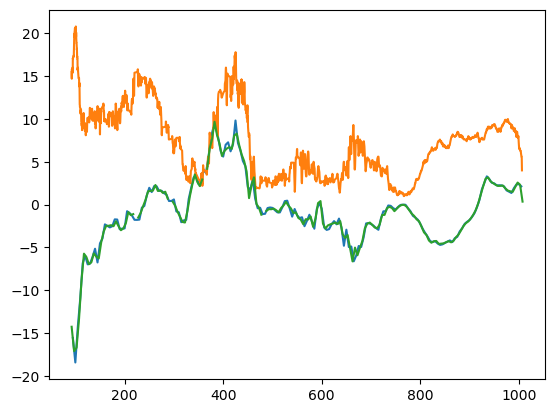

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x117da0610>

In [9]:
# test read a sounding

p, T,Td, rh,z, wspd,wdir, u,v = get_sounding_cols(df, station)

#=
# test plot
clf()
plot( m2n.(T), m2n.(p), label="Temperature (C)")
ylim(1000, 20)
station
=#

In [7]:
"extract column data by name"
function get_sounding_cols(df, station)
    if isempty(df)
        # p = [missing]
        # T = [missing]
        # Td = [missing]
        # rh= [missing]
        # z = [missing]
        # wspd = [missing]
        # wdir = [missing]
        p = []
        T = []
        Td = []
        rh= []
        z = []
        wspd = []
        wdir = []
    else
        if in(station, ["mangalore", "visakhapatnam", "portblair"])
            p = df[!,"P(hPa)"][:]
            T = df[!,"T(C)"][:]
            Td = df[!,"Dew(C)"][:]
            rh = df[!,"U(%)"][:]
            z = df[!,"Geo(gpm)"][:]
            wspd = df[!,"Wspd(m/s)"][:]
            wdir = df[!,"Wdir(d)"][:]
        else # slightly different keys
            p = df[!,"p(hPa)"][:]
            rh = df[!,"U(%)"][:]
            z = df[!,"Geo(gpm)"][:]
            wspd = df[!,"Wspd(m/s)"][:]
            if "T(dC)" in names(df)
                T = df[!,"T(dC)"][:]
                Td = df[!,"Dew(dC)"][:]
                wdir = df[!,"Wdir(d)"][:]
            elseif "T(Deg.C)" in names(df) # another variation
                T = df[!,"T(Deg.C)"][:]
                Td = df[!,"Dew(Deg.C)"][:]
                wdir = df[!,"Wdir(Deg)"][:]
            end

        end
    end
    u = -wspd .* sin.(pi/180.0*wdir)
    v = -wspd .* cos.(pi/180.0*wdir)
    
    return p, T,Td, rh,z, wspd,wdir, u,v
end

m2n (generic function with 1 method)

In [8]:
# sounding variable functions

meanfinite(x, dims) = sum(isfinite(x) ? x : 0, dims=dims)./sum(isfinite, x, dims=dims)
anom(x; dims=ndims(x)) = x .- meanfinite(x, dims)

"Exner function T/θ = (p/p_0)^Rd/cp"
Exner(p) = (p/1000.0)^0.287 # = T/theta
th(T,p) = T/Exner(p)

# put NaNs in for missing for matplotlib
m2n(x) = ismissing(x) ? NaN : x

th (generic function with 1 method)

In [10]:
# inventory files, times
station="visakhapatnam" # "visakhapatnam"
    # read standard named files in the station's directory
    files = soundingfiles(station)
    # deduplicate sounding times
    fdt = imd_file_date.(files)
    fdt12 = round.(fdt, Dates.Hour(12))
    ui = uniqueidx(fdt12)
    fdt[ui] # exact datetimes with duplicates removed
    ord = sortperm(fdt[ui]) # guarantees ascending order
    cat(files[ui[ord]], fdt[ui[ord]], dims=2)


# test read visakhapatanm
for ti in ui[ord]
    fn = joinpath(reldatapath, station, files[ti])
    df = read_sonde( joinpath(reldatapath, station, files[ti]) )
    @show files[ti]
    if !isempty(df)
        # extract ungridded hi-res data
        p_, T_,Td_, rh_,z_, wspd_,wdir_, u_,v_ = get_sounding_cols(df, station)
    end
end

files[ti] = "01MAY2023VSK.txt"
files[ti] = "02MAY2023VSK.txt"
files[ti] = "03MAY2023VSK.txt"
files[ti] = "04MAY2023VSK.txt"
files[ti] = "05MAY2023VSK.txt"
files[ti] = "06MAY2023VSK.txt"
files[ti] = "07MAY2023VSK.txt"
files[ti] = "08MAY2023VSK.txt"
files[ti] = "09MAY2023VSK.txt"
files[ti] = "10MAY2023VSK.txt"
files[ti] = "43150-20230511-00-Standard-Summary.txt"
files[ti] = "43150-20230512-00-Standard-Summary.txt"
files[ti] = "43150-20230513-00-Standard-Summary.txt"
files[ti] = "43150-20230514-00-Standard-Summary.txt"
files[ti] = "43150-20230515-00-Standard-Summary.txt"
files[ti] = "43150-20230516-00-Standard-Summary.txt"
files[ti] = "43150-20230517-00-Standard-Summary.txt"
files[ti] = "43150-20230518-00-Standard-Summary.txt"
files[ti] = "43150-20230519-00-Standard-Summary.txt"
files[ti] = "43150-20230520-00-Standard-Summary.txt"
files[ti] = "43150-20230521-00-Standard-Summary.txt"
files[ti] = "43150-20230522-00-Standard-Summary.txt"
files[ti] = "43150-20230523-00-Standard-Summary.txt"
f

In [11]:
# start over and do a big loop to load and interpolate data to consistent levels

# lexical defaults for grid_imd_sondes
reldatapath = "../data/EKAMSAT_IMD/ekamsat"
plevs = 1020.0:-5.0:0.0
CamelStations = ["Ahmedabad","Chennai","Karaikal","Kochi","Kolkata","Mangalore","PortBlair","Pune","Visakhapatnam"]
stationnames = lowercase.(CamelStations)

#=
# allocate gridded data arrays (pressure, location, launch time)
# for grid_imd_soundings! to update in-place.
nt = count_max_unique_soundings(stationnames)
# nt = 80 # allow for longest station mangalore?(37), extend & trim off extra later
time = zeros(DateTime, length(stationnames), nt)
T  = NaN.+zeros(Float64, length(plevs), length(stationnames), nt)
Td = NaN.+zeros(Float64, length(plevs), length(stationnames), nt)
rh = NaN.+zeros(Float64, length(plevs), length(stationnames), nt)
z  = NaN.+zeros(Float64, length(plevs), length(stationnames), nt)
u  = NaN.+zeros(Float64, length(plevs), length(stationnames), nt)
v  = NaN.+zeros(Float64, length(plevs), length(stationnames), nt)
=#

"read and grid IMD soundings to pressure levels."
function grid_imd_soundings!( time, T, Td, rh, z, u, v; 
                              plevs=plevs, stationnames=stationnames, reldatapath=reldatapath )
    for (sj, station) in enumerate(stationnames)
        @show station
        # read standard named files in the station's directory
        files = soundingfiles(station)
        # sj += 1 # gridded station index
        # deduplicate sounding times
        fdt = imd_file_date.(files)
        fdt12 = round.(fdt, Dates.Hour(12))
        ui = uniqueidx(fdt12)
        fdt[ui] # exact datetimes with duplicates removed
        ord = sortperm(fdt[ui]) # guarantees ascending order
        #collect(zip( files[ui[ord]]], fdt[ui[ord]] ))
        
        tj = 0
        for ti in ui[ord]
            fn = joinpath(reldatapath, station, files[ti])
            df = read_sonde( joinpath(reldatapath, station, files[ti]) )
            if !isempty(df)
                # extract ungridded hi-res data
                p_, T_,Td_, rh_,z_, wspd_,wdir_, u_,v_ = get_sounding_cols(df, station)
                # avg variables at the next time level
                tj += 1
                # update arrays in place
                time[sj,tj] = fdt[ti]
                T[  :, sj, tj] .= pavg(T_ , p_, plevs=plevs)
                Td[ :, sj, tj] .= pavg(Td_, p_, plevs=plevs)
                rh[ :, sj, tj] .= pavg(rh_, p_, plevs=plevs)
                z[  :, sj, tj] .= pavg(z_ , p_, plevs=plevs)
                u[  :, sj, tj] .= pavg(u_ , p_, plevs=plevs)
                v[  :, sj, tj] .= pavg(v_ , p_, plevs=plevs)
            else
                tj += 1
                time[sj,tj] =fdt[ti]
                # leave an empty sounding when missing
            end
        end
    end
    return # nothing
end

grid_imd_soundings!

In [12]:
# make time-height plot for each station

"sftp put file f to rendezvous.apl.washington.edu /incoming/sonde" # clunky, works
function put_file_apl( f )
    sftp_str = "sftp -P 2022 -i ~/.ssh/id_ed25519 sdeszoek@rendezvous.apl.washington.edu <<< 'put $(f) /incoming/sonde'"
    run(`sh -c $(sftp_str)`)
end

"output days from offset"
mpldate(timestamp, offset=DateTime(2023,4,30,0,0,0)) = Dates.value(timestamp-offset)/1000/60/60/24
#invmpldate( mlpd, offset=DateTime(2023,4,30,0,0,0) ) = mpldate+Dates.value(offset)/1000/60/60/24
mplday(d; offset=Date(2023,4,30)) = day(Day(d) + offset) # ticks

"Update plot all u,rh sounding timeheight profiles and put to APL."
function plot_timeheights( time, T, Td, rh, z, u, v )
    # count times at each station
    nts = sum(time.>DateTime(1000), dims=2)
    for sj in 1:9
        clf()
        subplot(2,1,1)
        pcolormesh( mpldate.(time[sj,1:nts[sj]]), plevs, u[:,sj,1:nts[sj]], vmin=-10, vmax=10, cmap=ColorMap("RdYlBu_r") )
        ylim(1000, 100)
        ylabel("u (m/s)")
        xtl,~ = xticks()
        xticks( xtl, mplday.(xtl,offset=Date(2023,4,30)) )
        colorbar()
        title(CamelStations[sj])
    
        subplot(2,1,2)
        pcolormesh( mpldate.(time[sj,1:nts[sj]]), plevs, rh[:,sj,1:nts[sj]], cmap=ColorMap("RdYlBu_r"))
        ylim(1000, 100)
        ylabel("RH (%)")
        xtl,~ = xticks()
        xticks( xtl, mplday.(xtl,offset=Date(2023,4,30)) )
        colorbar()
        xlabel(Dates.format(time[sj,1], "yyyy U"))
    
        figfile = "../plot/$(CamelStations[sj])_u_rh.svg"
        savefig( figfile )
        put_file_apl( figfile )
    end
end

plot_timeheights

In [13]:
"Write out pressure-gridded sonde data. Push new files to APL. Let old files stand."
function write_new_grid_sondes( time, T, Td, rh, z, u, v; stationnames )
    # count times at each station
    nts = sum(time.>DateTime(1000), dims=2)
    for (sj, station) in enumerate(stationnames)
        for tj in 1:nts[sj]
            fileout = joinpath("../data/EKAMSAT_IMD/grid_sondes/", Dates.format(time[sj,tj], "yyyymmdd-HH")*"_$(CamelStations[sj]).csv")
            if !isfile(fileout)
                # @show fileout
                dfo = DataFrame(  p=plevs,
                                  T=T[  :, sj, tj],
                                  Td=Td[:, sj, tj],
                                  rh=rh[:, sj, tj],
                                  z=z[  :, sj, tj],
                                  u=u[  :, sj, tj],
                                  v=v[  :, sj, tj]  )
                CSV.write( fileout, dfo )
                put_file_apl( fileout )
            end
        end
    end
end


write_new_grid_sondes

station = "ahmedabad"
station = "chennai"
station = "karaikal"
station = "kochi"
station = "kolkata"
station = "mangalore"
station = "portblair"
station = "pune"
station = "visakhapatnam"
sftp> put ../plot/Ahmedabad_u_rh.svg /incoming/sonde
Uploading ../plot/Ahmedabad_u_rh.svg to /incoming/sonde/Ahmedabad_u_rh.svg


Connected to rendezvous.apl.washington.edu.


sftp> put ../plot/Chennai_u_rh.svg /incoming/sonde
Uploading ../plot/Chennai_u_rh.svg to /incoming/sonde/Chennai_u_rh.svg


Connected to rendezvous.apl.washington.edu.


sftp> put ../plot/Karaikal_u_rh.svg /incoming/sonde
Uploading ../plot/Karaikal_u_rh.svg to /incoming/sonde/Karaikal_u_rh.svg


Connected to rendezvous.apl.washington.edu.


sftp> put ../plot/Kochi_u_rh.svg /incoming/sonde
Uploading ../plot/Kochi_u_rh.svg to /incoming/sonde/Kochi_u_rh.svg


Connected to rendezvous.apl.washington.edu.


sftp> put ../plot/Kolkata_u_rh.svg /incoming/sonde
Uploading ../plot/Kolkata_u_rh.svg to /incoming/sonde/Kolkata_u_rh.svg


Connected to rendezvous.apl.washington.edu.


sftp> put ../plot/Mangalore_u_rh.svg /incoming/sonde
Uploading ../plot/Mangalore_u_rh.svg to /incoming/sonde/Mangalore_u_rh.svg


Connected to rendezvous.apl.washington.edu.


sftp> put ../plot/PortBlair_u_rh.svg /incoming/sonde
Uploading ../plot/PortBlair_u_rh.svg to /incoming/sonde/PortBlair_u_rh.svg


Connected to rendezvous.apl.washington.edu.


sftp> put ../plot/Pune_u_rh.svg /incoming/sonde
Uploading ../plot/Pune_u_rh.svg to /incoming/sonde/Pune_u_rh.svg


Connected to rendezvous.apl.washington.edu.


sftp> put ../plot/Visakhapatnam_u_rh.svg /incoming/sonde
Uploading ../plot/Visakhapatnam_u_rh.svg to /incoming/sonde/Visakhapatnam_u_rh.svg


Connected to rendezvous.apl.washington.edu.


sftp> put ../data/EKAMSAT_IMD/grid_sondes/20230614-23_Chennai.csv /incoming/sonde
Uploading ../data/EKAMSAT_IMD/grid_sondes/20230614-23_Chennai.csv to /incoming/sonde/20230614-23_Chennai.csv


Connected to rendezvous.apl.washington.edu.
Connected to rendezvous.apl.washington.edu.


sftp> put ../data/EKAMSAT_IMD/grid_sondes/20230615-00_Karaikal.csv /incoming/sonde
Uploading ../data/EKAMSAT_IMD/grid_sondes/20230615-00_Karaikal.csv to /incoming/sonde/20230615-00_Karaikal.csv
sftp> put ../data/EKAMSAT_IMD/grid_sondes/20230614-23_Kochi.csv /incoming/sonde
Uploading ../data/EKAMSAT_IMD/grid_sondes/20230614-23_Kochi.csv to /incoming/sonde/20230614-23_Kochi.csv


Connected to rendezvous.apl.washington.edu.


sftp> put ../data/EKAMSAT_IMD/grid_sondes/20230615-00_Kolkata.csv /incoming/sonde
Uploading ../data/EKAMSAT_IMD/grid_sondes/20230615-00_Kolkata.csv to /incoming/sonde/20230615-00_Kolkata.csv


Connected to rendezvous.apl.washington.edu.


sftp> put ../data/EKAMSAT_IMD/grid_sondes/20230615-00_Mangalore.csv /incoming/sonde
Uploading ../data/EKAMSAT_IMD/grid_sondes/20230615-00_Mangalore.csv to /incoming/sonde/20230615-00_Mangalore.csv


Connected to rendezvous.apl.washington.edu.
Connected to rendezvous.apl.washington.edu.


sftp> put ../data/EKAMSAT_IMD/grid_sondes/20230615-00_Pune.csv /incoming/sonde
Uploading ../data/EKAMSAT_IMD/grid_sondes/20230615-00_Pune.csv to /incoming/sonde/20230615-00_Pune.csv
sftp> put ../data/EKAMSAT_IMD/grid_sondes/20230615-00_Visakhapatnam.csv /incoming/sonde
Uploading ../data/EKAMSAT_IMD/grid_sondes/20230615-00_Visakhapatnam.csv to /incoming/sonde/20230615-00_Visakhapatnam.csv


Connected to rendezvous.apl.washington.edu.


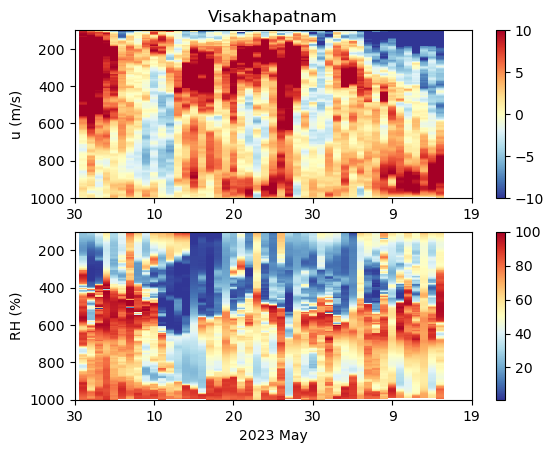

In [14]:
# do
# a big loop to read all sounding files, interpolate data to consistent levels
# output gridded files, and make plots

# reiterate parameters for paths, names, and gridding
reldatapath = "../data/EKAMSAT_IMD/ekamsat"
plevs = 1020.0:-5.0:0.0
CamelStations = ["Ahmedabad","Chennai","Karaikal","Kochi","Kolkata","Mangalore","PortBlair","Pune","Visakhapatnam"]
stationnames = lowercase.(CamelStations)

# allocate gridded data arrays (pressure, location, launch time)
nt = count_max_unique_soundings(stationnames)
# nt = 80 # allow for longest station mangalore?(37), extend & trim off extra later
time = zeros(DateTime, length(stationnames), nt)
T  = NaN.+zeros(Float64, length(plevs), length(stationnames), nt)
Td = NaN.+zeros(Float64, length(plevs), length(stationnames), nt)
rh = NaN.+zeros(Float64, length(plevs), length(stationnames), nt)
z  = NaN.+zeros(Float64, length(plevs), length(stationnames), nt)
u  = NaN.+zeros(Float64, length(plevs), length(stationnames), nt)
v  = NaN.+zeros(Float64, length(plevs), length(stationnames), nt)

grid_imd_soundings!( time, T, Td, rh, z, u, v; plevs=plevs, stationnames=stationnames, reldatapath=reldatapath )

plot_timeheights( time, T, Td, rh, z, u, v )
write_new_grid_sondes( time, T, Td, rh, z, u, v; stationnames )

cat(CamelStations, nts, dims = 2) = Any["Ahmedabad" 43; "Chennai" 47; "Karaikal" 44; "Kochi" 44; "Kolkata" 46; "Mangalore" 45; "PortBlair" 42; "Pune" 45; "Visakhapatnam" 46]
size(u[:, sj, 1:nts[sj]]) = (205, 43)


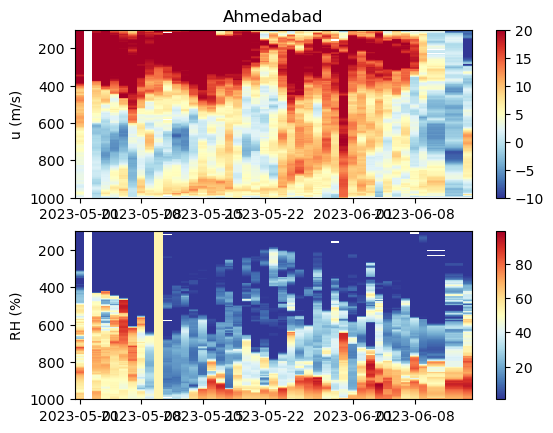

PyObject <matplotlib.colorbar.Colorbar object at 0x118177c70>

In [15]:
# tests

# count times at each station
nts = sum(time.>DateTime(1000), dims=2)
@show cat(CamelStations, nts, dims=2)


# test time-pressure plot at one station
sj = 1
@show size(u[:,sj,1:nts[sj]])

clf()
subplot(2,1,1)
# pcolormesh( time[sj,:], plevs, anom(T[:,sj,:],dims=2) )
# pcolormesh( time[sj,:], plevs, anom(th.(T[:,sj,:],plevs),dims=2), vmin=-7, vmax=7, cmap=ColorMap("RdYlBu_r") )
pcolormesh( time[sj,1:nts[sj]], plevs, u[:,sj,1:nts[sj]], vmin=-10, vmax=20, cmap=ColorMap("RdYlBu_r") )
ylim(1000, 100)
colorbar()
ylabel("u (m/s)")
title(CamelStations[sj])

subplot(2,1,2)
pcolormesh( time[sj,1:nts[sj]], plevs, rh[:,sj,1:nts[sj]], cmap=ColorMap("RdYlBu_r"))
ylim(1000, 100)
ylabel("RH (%)")
colorbar()